### IMPORT LIBRARIES

In [61]:
import pandas as pd
import json
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score , roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import re
import string
import nltk
from nltk.tokenize import word_tokenize #to tokenize the column
from nltk.stem.snowball import SnowballStemmer # To stem the each word
#nltk.download('stopwords')
from nltk.corpus import stopwords #to generate stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from time import time

### READ DATA

In [63]:
# data containing all product category
data= pd.read_json('computers_train_xlarge.json' , lines=True)

In [3]:
# gold standard data for all categories
data_gs= pd.read_json('computers_gs.json' , lines=True)

In [4]:
# test set containing all categories
test_set = pd.read_json('task1_testset_1500_with_labels.json' , lines=True)

### VIEW WHAT THE DATA LOOK LIKE

In [5]:
data.head(2)

,id_left,category_left,cluster_id_left,id_right,category_right,cluster_id_right,label,pair_id,brand_left,brand_right,description_left,description_right,keyValuePairs_left,keyValuePairs_right,price_left,price_right,specTableContent_left,specTableContent_right,title_left,title_right
0,2551242,Computers_and_Accessories,79457,16272671,Computers_and_Accessories,79457,1,2551242#16272671,"""Corsair""@en",None,"""DDR4, 2666MHz, CL16, 1.2v, XMP 2.0, Lifetime ...",None,"{'Memory Type': 'DDR4 (PC4-21300)', 'Capacity'...","{'Categorie': 'Geheugen intern', 'Merk': 'Cors...",None,None,Memory Type DDR4 (PC4-21300) Capacity 64GB (4...,Categorie Geheugen intern Merk Corsair Produc...,"""Corsair Vengeance LPX Black 64GB (4x16GB) DD...","""Corsair Vengeance LPX CMK64GX4M4A2666C16 - P..."
1,16757469,Computers_and_Accessories,63553,16476204,Computers_and_Accessories,63553,1,16757469#16476204,"""HP Enterprise""","""HP Enterprise""","""Description:2 x 72GB 2.5-inch Serial Attached...","""Description:10 x 72GB 2.5-inch Serial Attach...","{'Category': 'Proliant HardDrive', 'Sub-Catego...","{'Category': 'Proliant HardDrive', 'Sub-Catego...",None,"""CAD"", ""$757.74 CAD""",Specifications: Category Proliant HardDrive S...,Specifications: Category Proliant HardDrive S...,"""DH0072BALWL HP 72-GB 3G 15K 2.5 DP SAS"", ""Nu...","""DH0072BALWL HP 72-GB 3G 15K 2.5 DP SAS"" ""Null"""


In [6]:
test_set.head(2)

,id_left,cluster_id_left,category_left,title_left,description_left,brand_left,price_left,keyValuePairs_left,specTableContent_left,id_right,...,category_right,title_right,description_right,brand_right,price_right,keyValuePairs_right,specTableContent_right,label,pair_id,sampling
0,4210789,533129,Computers_and_Accessories,"""Intel X520-DA2 PCI Express 2.0 Network Adapt...","""Intel's family of adapter, the Intel' Etherne...",None,"""$"", ""333.16""",None,None,6428629,...,Computers_and_Accessories,"""Intel X520-DA2 Dual Port Gigabit SFP Etherne...","""2 Port Intel E10G42BTDA 10 Gigabit SFP Ethern...",None,None,None,None,1,4210789#6428629,high similarity with old products
1,8813989,55385,Computers_and_Accessories,"""Zotac GeForce GTX 1070Ti AMP Extreme 8192MB ...","""ZT-P10710B-10P, Core Clock: 1607MHz, Boost Cl...","""Zotac""@en",None,None,None,4435647,...,Computers_and_Accessories,"""Zotac NVIDIA GeForce GTX 1070 Ti 8GB AMP! Ex...","""Zotac GeForce GTX 1070 Ti AMP! Extreme Editio...",None,None,None,None,1,8813989#4435647,high similarity with old products


In [7]:
data_gs.head(2)

,id_left,category_left,cluster_id_left,identifiers_left,id_right,category_right,cluster_id_right,identifiers_right,label,pair_id,...,description_left,description_right,keyValuePairs_left,keyValuePairs_right,price_left,price_right,specTableContent_left,specTableContent_right,title_left,title_right
0,581109,Computers_and_Accessories,1324529,"[{'/mpn': '[gvrx480g1gaming4gd]'}, {'/gtin13':...",16637861,Computers_and_Accessories,107415,"[{'/mpn': '[gvrx550gamingoc2gd]'}, {'/gtin13':...",0,581109#16637861,...,"""GV-RX480G1 GAMING-4GD, Core Clock: 1202MHz, B...","""GV-RX550GAMING OC-2GD, Boost: 1219MHz, Memory...",None,None,None,None,None,None,"""Gigabyte Radeon RX 480 G1 Gaming 4096MB GDDR...","""Gigabyte Radeon RX 550 Gaming OC 2048MB GDDR..."
1,3083228,Computers_and_Accessories,640007,"[{'/mpn': '[9hlf4lbdbe]'}, {'/gtin13': '[47187...",3424944,Computers_and_Accessories,640007,"[{'/mpn': '[9hlf4lbdbe]'}, {'/gtin13': '[47187...",1,3083228#3424944,...,"""\n More>>>\n \n...","""\n\n Every det...",None,None,None,None,None,None,"""Benq ZOWIE RL2455 24"" Full HD TN Grey comput...","""Zowie RL2455 E-Sports 24"" Full HD LED Monito..."


## View the shape of each dataset 


In [8]:
data.shape

(68461, 20)

In [9]:
test_set.shape

(1500, 21)

In [10]:
data_gs.shape

(1100, 22)

- As we can see above, each data have different number of columns. On a closer look, the column "sampling" is present in the test_set, but missing in the remaining two columns. 
- Also, the columns "identifiers_left" and "identifiers_right" are present data_gs , but missing in test_set. we need to drop the columns "sampling" , "identifiers_left" and "identifiers_right"


In [11]:
data_gs = data_gs.drop(['identifiers_right' , 'identifiers_left'] , axis=1)

In [12]:
test_set = test_set.drop(['sampling'] , axis=1)

### VIEW THE SHAPE OF THE DATA AFTER DROPPING SOME COLUMNS

In [13]:
data.shape

(68461, 20)

In [14]:
test_set.shape

(1500, 20)

In [15]:
data_gs.shape

(1100, 20)

### VIEW THE EXTENT OF MISSING DATA

#### columns with missing data in data dataset

In [64]:
print("Are there any null values?")
print(data.isnull().values.any() , "\n")
#Find out how many - This gives you the breakdown per column
print('How many null values are in each column?'),
print(data.isnull().sum(), "\n")
#Get total overall null values
print('How many null values are in the data in total?')
print(data.isnull().sum().sum())

Are there any null values?
True 

How many null values are in each column?
id_left                       0
category_left                 0
cluster_id_left               0
id_right                      0
category_right                0
cluster_id_right              0
label                         0
pair_id                       0
brand_left                34228
brand_right               34216
description_left          21001
description_right         20101
keyValuePairs_left        49696
keyValuePairs_right       48186
price_left                56940
price_right               56969
specTableContent_left     47564
specTableContent_right    46304
title_left                    0
title_right                   0
dtype: int64 

How many null values are in the data in total?
415205


#### columns with missing data in test_set dataset

In [62]:
print("Are there any null values in the test_set?")
print(test_set.isnull().values.any() , "\n")
#Find out how many - This gives you the breakdown per column
print('How many null values are in each column?'),
print(test_set.isnull().sum(), "\n")
#Get total overall null values
print('How many null values are in the data in total?')
print(test_set.isnull().sum().sum())

Are there any null values in the test_set?
True 

How many null values are in each column?
id_left                      0
cluster_id_left              0
category_left                0
title_left                   0
description_left           167
brand_left                 635
price_left                1161
keyValuePairs_left        1025
specTableContent_left      995
id_right                     0
cluster_id_right             0
category_right               0
title_right                  0
description_right          219
brand_right                644
price_right               1156
keyValuePairs_right       1076
specTableContent_right    1030
label                        0
pair_id                      0
dtype: int64 

How many null values are in the data in total?
8108


#### columns with missing data in Gold standard dataset

In [18]:
print("Are there any null values in the data_gs?")
print(data_gs.isnull().values.any() , "\n")
#Find out how many - This gives you the breakdown per column
print('How many null values are in each column?'),
print(data_gs.isnull().sum(), "\n")
#Get total overall null values
print('How many null values are in the data in total?')
print(data_gs.isnull().sum().sum())

Are there any null values in the data_gs?
True 

How many null values are in each column?
id_left                     0
category_left               0
cluster_id_left             0
id_right                    0
category_right              0
cluster_id_right            0
label                       0
pair_id                     0
brand_left                438
brand_right               460
description_left           78
description_right         140
keyValuePairs_left        719
keyValuePairs_right       766
price_left                846
price_right               840
specTableContent_left     698
specTableContent_right    736
title_left                  0
title_right                 0
dtype: int64 

How many null values are in the data in total?
5721


#### DROP MISSING VALUES

In [19]:
data0=data.dropna()
test_set0= test_set.dropna()
data_gs0 =data_gs.dropna()

In [20]:
data0.shape

(1450, 20)

In [21]:
test_set0.shape

(59, 20)

In [22]:
data_gs0.shape

(49, 20)

#### Comment
- As we can see above the missing values are too much. For data dataset, about 98 percent of the data are gone
- for test_set , 96 percent are deleted.
- Also ,in the gold standard dataset , 96 percent of the dataset have been phased out.

- The remaining data is not enough for training most machine learning algorithms and also might not be enough to model the    whole dataset
- We will replace all null values with blank(" "), then combine all features to one column. This is to ensure that we use all possible information for our classification.

# EXPERIMENT 1:
#### USING ALL COLUMNS TO FIT MODEL

#### COMBINING ALL FEATURES TOGETHER

In [23]:
data1 = data.copy(deep=True) 
data1 = data1.fillna('')
data1['product_feature'] = str(data1['id_left']) + " " +str(data1['category_left']) + " " + str(data1['cluster_id_left']) + " " + str(data1['id_right']) + " " + data1['category_right']+ " " + str(data1['cluster_id_right'])+ " " + data1['brand_left']+ " " + data1['brand_right']+ " " + data1['description_left']+ " " + data1['description_right']+ " " + str(data1['keyValuePairs_left'])+ " " + str(data1['keyValuePairs_right'])+ " " + str(data1['price_left'])+  " " +str(data1['price_right'])+ " " + data1['specTableContent_left']+ " " + data1['specTableContent_right']+ " " + data1['title_left']+  " " +data1['title_right']
data1.drop(data1.columns.difference(['product_feature','label']), 1, inplace=True)

test_set1 = test_set.copy(deep=True) 
test_set1 = test_set1.fillna('')
test_set1['product_feature'] = str(test_set1['id_left']) +  " " +str(test_set1['category_left']) +  " " +str(test_set1['cluster_id_left']) + " " + str(test_set1['id_right']) +  " " +test_set1['category_right']+ " " + str(test_set1['cluster_id_right'])+ " " + test_set1['brand_left']+ " " + test_set1['brand_right']+  " " +test_set1['description_left']+ " " + test_set1['description_right']+ " " + str(test_set1['keyValuePairs_left'])+ " " + str(test_set1['keyValuePairs_right'])+ " " + str(test_set1['price_left'])+ " " + str(test_set1['price_right'])+ " " + test_set1['specTableContent_left']+ " " + test_set1['specTableContent_right']+ " " + test_set1['title_left']+ " " + test_set1['title_right']
test_set1.drop(test_set1.columns.difference(['product_feature','label']), 1, inplace=True)

data_gs1 = data_gs.copy(deep=True)
data_gs1 = data_gs1.fillna('')
data_gs1['product_feature'] = str(data_gs1['id_left']) +  " " +str(data_gs1['category_left']) + " " + str(data_gs1['cluster_id_left']) + " " + str(data_gs1['id_right']) + " " + data_gs1['category_right']+ " " + str(data_gs1['cluster_id_right'])+  " " +data_gs1['brand_left']+  " " +data_gs1['brand_right']+  " " +data_gs1['description_left']+  " " +data_gs1['description_right']+ " " + str(data_gs1['keyValuePairs_left'])+ " " + str(data_gs1['keyValuePairs_right'])+ " " + str(data_gs1['price_left'])+ " " + str(data_gs1['price_right'])+ " " + data_gs1['specTableContent_left']+  " " +data_gs1['specTableContent_right']+ " " + data_gs1['title_left']+ " " + data_gs1['title_right']
data_gs1.drop(data_gs1.columns.difference(['product_feature','label']), 1, inplace=True)

C:\Users\pc\AppData\Local\Temp/ipykernel_4272/3806188373.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  data1.drop(data1.columns.difference(['product_feature','label']), 1, inplace=True)
C:\Users\pc\AppData\Local\Temp/ipykernel_4272/3806188373.py:9: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  test_set1.drop(test_set1.columns.difference(['product_feature','label']), 1, inplace=True)
C:\Users\pc\AppData\Local\Temp/ipykernel_4272/3806188373.py:14: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  data_gs1.drop(data_gs1.columns.difference(['product_feature','label']), 1, inplace=True)


- In the above cell, the null values were filled with empty space, i.e ' ', then the columns were merged together. 
- This means that the model that will be created with this data will be robust enough to predict outcomes using either all the columns or some of the columns.

#### VIEW THE FIRST FIVE DATASET AFTER COLUMN MERGING

In [24]:
data1.head()

,label,product_feature
0,1,0 2551242\n1 16757469\n2 ...
1,1,0 2551242\n1 16757469\n2 ...
2,0,0 2551242\n1 16757469\n2 ...
3,1,0 2551242\n1 16757469\n2 ...
4,0,0 2551242\n1 16757469\n2 ...


In [25]:
test_set1.head()

,label,product_feature
0,1,0 4210789\n1 8813989\n2 4...
1,1,0 4210789\n1 8813989\n2 4...
2,1,0 4210789\n1 8813989\n2 4...
3,1,0 4210789\n1 8813989\n2 4...
4,1,0 4210789\n1 8813989\n2 4...


In [26]:
data_gs1.head()

,label,product_feature
0,0,0 581109\n1 3083228\n2 5...
1,1,0 581109\n1 3083228\n2 5...
2,0,0 581109\n1 3083228\n2 5...
3,0,0 581109\n1 3083228\n2 5...
4,0,0 581109\n1 3083228\n2 5...


#### VIEW SOME DATA PARAMETERS

- COUNT OF ZEROS AND ONES IN LABEL COLUMN FOR data1

In [27]:
data1.label.value_counts(normalize=True)

0    0.85846
1    0.14154
Name: label, dtype: float64

<AxesSubplot:>

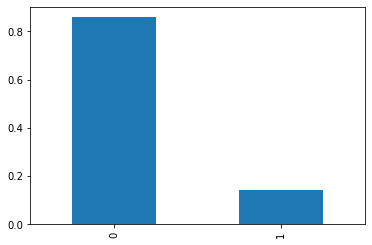

In [28]:
data1.label.value_counts(normalize=True).sort_index().plot(kind='bar')

- COUNT OF ZEROS AND ONES IN LABEL COLUMN FOR test_set1

In [29]:
test_set1.label.value_counts(normalize=True)

0    0.65
1    0.35
Name: label, dtype: float64

<AxesSubplot:>

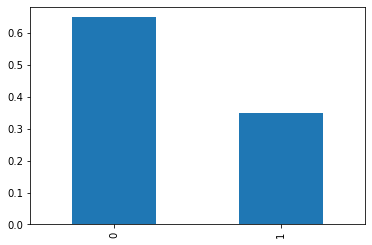

In [30]:
test_set1.label.value_counts(normalize=True).sort_index().plot(kind='bar')

- COUNT OF ZEROS AND ONES IN LABEL COLUMN FOR data_gs1

In [31]:
data_gs1.label.value_counts(normalize=True)

0    0.727273
1    0.272727
Name: label, dtype: float64

<AxesSubplot:>

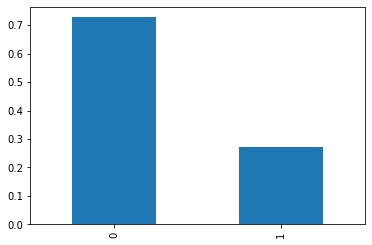

In [32]:
data_gs1.label.value_counts(normalize=True).sort_index().plot(kind='bar')

#### DROP NULL VALUES

In [33]:
data1=data1.dropna()
test_set1= test_set1.dropna()
data_gs1 =data_gs1.dropna()

#### VIEW THE SHAPE OF THE DATASETS AFTER DROPPING NULL VALUES

In [34]:
data1.shape

(68461, 2)

In [35]:
test_set1.shape

(1500, 2)

In [36]:
data_gs1.shape

(1100, 2)

#### function definition and generating stopwords
- the function "remove_punctuation" will remove punctuaions from columns, and "tokenize" will tokenize and stem the words to root words in the the column

In [37]:
#library that contains punctuation
string.punctuation

#Define function to remove punctuation
def remove_punctuation(text):
    punctuationfree="".join([i for i in text if i not in string.punctuation])
    return punctuationfree

#Generate stopwords
english_stopwords=stopwords.words('english')
# Generate Stemmer
stemmer= SnowballStemmer(language='english')

# Define tokenizer function with stemmer
def tokenize(text):
            return [stemmer.stem(token) for token in word_tokenize(text)]

In [38]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [39]:
tokenize('do you like driving')

['do', 'you', 'like', 'drive']

#### Apply the function remove_punctuation to column

In [40]:
data1['product_feature'] = data1['product_feature'].apply(lambda x:remove_punctuation(x))
test_set1['product_feature'] = test_set1['product_feature'].apply(lambda x:remove_punctuation(x))
data_gs1['product_feature'] = data_gs1['product_feature'].apply(lambda x:remove_punctuation(x))

In [41]:
data1.head()

,label,product_feature
0,1,0 2551242\n1 16757469\n2 ...
1,1,0 2551242\n1 16757469\n2 ...
2,0,0 2551242\n1 16757469\n2 ...
3,1,0 2551242\n1 16757469\n2 ...
4,0,0 2551242\n1 16757469\n2 ...


In [42]:
data_gs1.head()

,label,product_feature
0,0,0 581109\n1 3083228\n2 5...
1,1,0 581109\n1 3083228\n2 5...
2,0,0 581109\n1 3083228\n2 5...
3,0,0 581109\n1 3083228\n2 5...
4,0,0 581109\n1 3083228\n2 5...


#### create a TF-IDF model using Tfidf vectorizer function.

In [43]:
from time import time
t0 = time()
vectorizer = TfidfVectorizer(tokenizer=tokenize , 
                             stop_words=english_stopwords,
                            ngram_range=(1,1) , max_df=0.5 , max_features= 1000
                            )
duration = time() - t0
print('Duration:' , duration ,'seconds')

Duration: 0.001001119613647461 seconds


#### Fit TF-IDF model on product_feature column

In [44]:
from time import time
t0 = time()
vectorizer.fit(data1.product_feature)
duration = time() - t0
print('Duration:' , duration/60 ,'minutes')

C:\Users\pc\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:489: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"
C:\Users\pc\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'s", 'abov', 'ani', 'becaus', 'befor', 'could', 'doe', 'dure', 'might', 'must', "n't", 'need', 'onc', 'onli', 'ourselv', 'sha', 'themselv', 'veri', 'whi', 'wo', 'would', 'yourselv'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


Duration: 13.010171596209208 minutes


### Transform Training , gold standard data and test data

In [45]:
t0 = time()
inputs = pd.DataFrame(
            vectorizer.transform(data1.product_feature).toarray(), columns=vectorizer.vocabulary_
        )
test_inputs = pd.DataFrame(
            vectorizer.transform(test_set1.product_feature).toarray(), columns=vectorizer.vocabulary_
        )
gs_inputs = pd.DataFrame(
            vectorizer.transform(data_gs1.product_feature).toarray(), columns=vectorizer.vocabulary_
)
duration = time() - t0
print('Duration:' , duration ,'seconds')
print('inputs.shape =' , inputs.shape)
print('test_inputs.shape =' , test_inputs.shape)
print('gs_inputs.shape =' , gs_inputs.shape)

Duration: 787.4505844116211 seconds
inputs.shape = (68461, 1000)
test_inputs.shape = (1500, 1000)
gs_inputs.shape = (1100, 1000)


#### Split the Training data into train and validation, test data and gold standard data into labels and features

In [46]:
# Split Training data into train and validation
X_train , X_val , y_train , y_val = train_test_split(inputs , data1.label , test_size= 0.3 , random_state=42)
# Split test data into labels and features
X_test=test_inputs 
y_test = test_set1.label
# Split test data into labels and features
X_gs =gs_inputs
y_gs= data_gs1.label

In [47]:
X_train.shape

(47922, 1000)

### Initial Accuracy Test for Potential Models using K fold Evaluation

In [48]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn import model_selection
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
#log_model = LogisticRegression(solver='sag')
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
import matplotlib.pyplot as plt

seed = 42

models = []
models.append(('LR', LogisticRegression(solver='sag')))
models.append(('RF', RandomForestClassifier()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))

#Evaluate each model
results = []
names = []
scoring = 'accuracy'

for name, model in models:
    kfold = model_selection.KFold(n_splits = 10, random_state = seed , shuffle=True)
    cv_results = model_selection.cross_val_score(model,X_train , y_train.ravel(), cv=kfold, scoring=scoring)
    model.fit(X_train, y_train)
    Y_pred = model.predict(X_val)
    
    results.append(cv_results)
    names.append(name)
    print('Model Name: ' , name)
    print('Cross value mean: ' , cv_results.mean())
    print('Cross value Standard Deviation: ', cv_results.std())
    print('\nClassification Report')
    print(classification_report(y_val, Y_pred))
    print('=============================================================================================================\n')

Model Name:  LR
Cross value mean:  0.8640706597023275
Cross value Standard Deviation:  0.005662060500035681

Classification Report
              precision    recall  f1-score   support

           0       0.86      1.00      0.92     17568
           1       0.77      0.06      0.11      2971

    accuracy                           0.86     20539
   macro avg       0.81      0.53      0.52     20539
weighted avg       0.85      0.86      0.81     20539


Model Name:  RF
Cross value mean:  0.8959351065671383
Cross value Standard Deviation:  0.0053568714279827795

Classification Report
              precision    recall  f1-score   support

           0       0.91      0.98      0.94     17568
           1       0.74      0.42      0.53      2971

    accuracy                           0.89     20539
   macro avg       0.83      0.70      0.74     20539
weighted avg       0.88      0.89      0.88     20539


Model Name:  KNN
Cross value mean:  0.8689118835307612
Cross value Standard Devia

- Comment: out of the models tried, logistic regression and decision tree classifier both have accuracy of 86% , K- Nearest neighbours algorithm fared better with accuracu of 87%, while random forest classifier ranked top with accuracy of 89%. So i picked random forest classifier out of all.

## Fit the random forest model

In [49]:
model = RandomForestClassifier(random_state=42)
model.fit(X_train , y_train )

RandomForestClassifier(random_state=42)

## Evaluate the model on validation data

Accuracy =  0.8936657091387117
[[17143   425]
 [ 1759  1212]]


C:\Users\pc\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass display_labels=[0 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


              precision    recall  f1-score   support

    nonmatch       0.91      0.98      0.94     17568
       match       0.74      0.41      0.53      2971

    accuracy                           0.89     20539
   macro avg       0.82      0.69      0.73     20539
weighted avg       0.88      0.89      0.88     20539

ROC Score: 0.6919


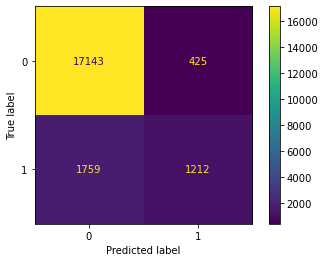

In [50]:
### Evaluate model on validation data
y_pred= model.predict(X_val)
print("Accuracy = " , metrics.accuracy_score(y_val, y_pred))
cm= confusion_matrix(y_val, y_pred)
print(cm)
ConfusionMatrixDisplay(cm, model.classes_).plot()
print(metrics.classification_report(y_val, y_pred, target_names=['nonmatch', 'match']))

from sklearn.metrics import roc_auc_score
# Calculate the ROC score
roc_score = roc_auc_score(y_val, y_pred)

# Print the ROC score
print("ROC Score: {:.4f}".format(roc_score))

#### Evaluate model on test data

Accuracy =  0.66
[[974   1]
 [509  16]]


C:\Users\pc\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass display_labels=[0 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


              precision    recall  f1-score   support

    nonmatch       0.66      1.00      0.79       975
       match       0.94      0.03      0.06       525

    accuracy                           0.66      1500
   macro avg       0.80      0.51      0.43      1500
weighted avg       0.76      0.66      0.54      1500

ROC Score: 0.5147


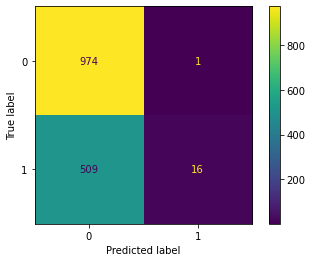

In [51]:
### Evaluate model on test data
y_pred= model.predict(X_test)
print("Accuracy = " , metrics.accuracy_score(y_test, y_pred))
cm= confusion_matrix(y_test, y_pred)
print(cm)
ConfusionMatrixDisplay(cm, model.classes_).plot()
print(metrics.classification_report(y_test, y_pred, target_names=['nonmatch', 'match']))

# Calculate the ROC score
roc_score = roc_auc_score(y_test, y_pred)

# Print the ROC score
print("ROC Score: {:.4f}".format(roc_score))

#### Evaluate model on gold standard data

Accuracy =  0.7781818181818182
[[781  19]
 [225  75]]


C:\Users\pc\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass display_labels=[0 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


              precision    recall  f1-score   support

    nonmatch       0.78      0.98      0.86       800
       match       0.80      0.25      0.38       300

    accuracy                           0.78      1100
   macro avg       0.79      0.61      0.62      1100
weighted avg       0.78      0.78      0.73      1100

ROC Score: 0.6131


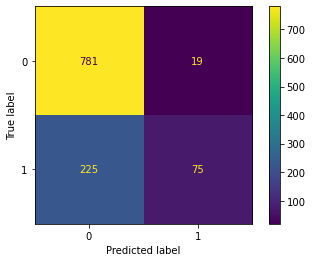

In [52]:
### Evaluate model on gold standard data
y_gs_pred= model.predict(X_gs)
print("Accuracy = " , metrics.accuracy_score(y_gs, y_gs_pred))
cm= confusion_matrix(y_gs, y_gs_pred)
print(cm)
ConfusionMatrixDisplay(cm, model.classes_).plot()
print(metrics.classification_report(y_gs, y_gs_pred, target_names=['nonmatch', 'match']))

from sklearn.metrics import roc_auc_score
# Calculate the ROC score
roc_score = roc_auc_score(y_gs, y_gs_pred)

# Print the ROC score
print("ROC Score: {:.4f}".format(roc_score))

As the dataset in the above experiment is large, conducting a randomised search for hyperparameter is time consuming., I will use the method suggested by Huijskens, T. (2016) to find the hyperparameters
https://thuijskens.github.io/2016/12/29/bayesian-optimisation/#parameter-selection-of-a-support-vector-machine

## Hyperparameter Tuning 

In [53]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# Generate synthetic dataset
data= X_train
target = y_train
data, target = make_classification(n_samples=2000,
                                   n_features=1000,
                                   random_state=42)  # Set a specific random state for reproducibility

# Split the dataset into training and testing sets
X_train01, X_test01, y_train01, y_test01 = train_test_split(data, target, test_size=0.3, random_state=42)

# Create a Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the classifier to the training data
rf_classifier.fit(X_train01, y_train01)

# Evaluate the classifier on the testing data
accuracy = rf_classifier.score(X_test01, y_test01)
print("Accuracy:", accuracy)


Accuracy: 0.8783333333333333


In [54]:
###  Implementing Random Search Using Scikit-Learn
##### Defining the Hyperparameter Space
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV
import numpy as np
rs_space={'max_depth':list(np.arange(1, 100, step=10)) + [None],
              'n_estimators':np.arange(10, 500, step=50),
              'max_features':randint(1,7),
              'criterion':['gini','entropy'],
              'min_samples_leaf':randint(1,4),
              'min_samples_split':np.arange(2, 10, step=2)
         }

rf = RandomForestClassifier()
rf_random = RandomizedSearchCV(rf, rs_space, n_iter=100, scoring='accuracy', n_jobs=-1, cv=3)
model_random = rf_random.fit(X_train01,y_train01)


print('Best grid search hyperparameters are: '+str(model_random.best_params_))
print('Best grid search score is: '+str(model_random.best_score_))

Best grid search hyperparameters are: {'criterion': 'entropy', 'max_depth': 11, 'max_features': 6, 'min_samples_leaf': 1, 'min_samples_split': 8, 'n_estimators': 410}
Best grid search score is: 0.8814335560436598


### Evaluate the hypertuned model on validation data

Accuracy =  0.14786503724621453
[[   75 17493]
 [    9  2962]]


C:\Users\pc\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass display_labels=[0 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


              precision    recall  f1-score   support

    nonmatch       0.89      0.00      0.01     17568
       match       0.14      1.00      0.25      2971

    accuracy                           0.15     20539
   macro avg       0.52      0.50      0.13     20539
weighted avg       0.78      0.15      0.04     20539

ROC Score: 0.5006


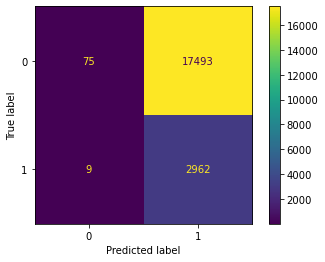

In [55]:
### Evaluate model on validation data
y_pred= model_random.predict(X_val)
print("Accuracy = " , metrics.accuracy_score(y_val, y_pred))
cm= confusion_matrix(y_val, y_pred)
print(cm)
ConfusionMatrixDisplay(cm, model.classes_).plot()
print(metrics.classification_report(y_val, y_pred, target_names=['nonmatch', 'match']))

from sklearn.metrics import roc_auc_score
# Calculate the ROC score
roc_score = roc_auc_score(y_val, y_pred)

# Print the ROC score
print("ROC Score: {:.4f}".format(roc_score))

### Evaluate hypertuned model on test data

Accuracy =  0.35
[[  4 971]
 [  4 521]]
              precision    recall  f1-score   support

    nonmatch       0.50      0.00      0.01       975
       match       0.35      0.99      0.52       525

    accuracy                           0.35      1500
   macro avg       0.42      0.50      0.26      1500
weighted avg       0.45      0.35      0.19      1500

ROC Score: 0.4982


C:\Users\pc\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass display_labels=[0 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


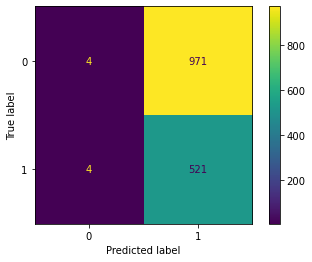

In [56]:
### Evaluate model on test data
y_pred= model_random.predict(X_test)
print("Accuracy = " , metrics.accuracy_score(y_test, y_pred))
cm= confusion_matrix(y_test, y_pred)
print(cm)
ConfusionMatrixDisplay(cm, model.classes_).plot()
print(metrics.classification_report(y_test, y_pred, target_names=['nonmatch', 'match']))

# Calculate the ROC score
roc_score = roc_auc_score(y_test, y_pred)

# Print the ROC score
print("ROC Score: {:.4f}".format(roc_score))

### Evaluate hypertuned model on gold standard data

Accuracy =  0.2736363636363636
[[  3 797]
 [  2 298]]
              precision    recall  f1-score   support

    nonmatch       0.60      0.00      0.01       800
       match       0.27      0.99      0.43       300

    accuracy                           0.27      1100
   macro avg       0.44      0.50      0.22      1100
weighted avg       0.51      0.27      0.12      1100

ROC Score: 0.4985


C:\Users\pc\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass display_labels=[0 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


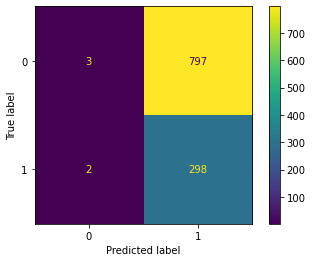

In [57]:
### Evaluate model on gold standard data
y_gs_pred= model_random.predict(X_gs)
print("Accuracy = " , metrics.accuracy_score(y_gs, y_gs_pred))
cm= confusion_matrix(y_gs, y_gs_pred)
print(cm)
ConfusionMatrixDisplay(cm, model.classes_).plot()
print(metrics.classification_report(y_gs, y_gs_pred, target_names=['nonmatch', 'match']))

from sklearn.metrics import roc_auc_score
# Calculate the ROC score
roc_score = roc_auc_score(y_gs, y_gs_pred)

# Print the ROC score
print("ROC Score: {:.4f}".format(roc_score))

## EXPERIMENT 2:
#### WORKING WITH COLUMNS WITH LESS THAN 40,000 MISSING VALUES ,THEN DROPPING THE NULL VALUES


#### Recall the data from above.

In [65]:
print("Are there any null values?")
print(data.isnull().values.any() , "\n")
#Find out how many - This gives you the breakdown per column
print('How many null values are in each column?'),
print(data.isnull().sum(), "\n")
#Get total overall null values
print('How many null values are in the data in total?')
print(data.isnull().sum().sum())

Are there any null values?
True 

How many null values are in each column?
id_left                       0
category_left                 0
cluster_id_left               0
id_right                      0
category_right                0
cluster_id_right              0
label                         0
pair_id                       0
brand_left                34228
brand_right               34216
description_left          21001
description_right         20101
keyValuePairs_left        49696
keyValuePairs_right       48186
price_left                56940
price_right               56969
specTableContent_left     47564
specTableContent_right    46304
title_left                    0
title_right                   0
dtype: int64 

How many null values are in the data in total?
415205


- six columns have more than 40000 missing values:
- The columns are:'specTableContent_left'
                    'specTableContent_right' 
                    'keyValuePairs_left'  
                    'keyValuePairs_right' 
                    'price_left' and
                    'price_right'

#### Dropping the six columns that have more than 40,000 missing values in the dataset

In [66]:
data2 = data.drop(['specTableContent_left' , 'specTableContent_right' , 'keyValuePairs_left' , 'keyValuePairs_right' , 'price_left' , 'price_right'] , axis=1)
test_set2= test_set.drop(['specTableContent_left' , 'specTableContent_right' , 'keyValuePairs_left' , 'keyValuePairs_right' , 'price_left' , 'price_right'] , axis=1)
data_gs2= data_gs.drop(['specTableContent_left' , 'specTableContent_right' , 'keyValuePairs_left' , 'keyValuePairs_right' , 'price_left' , 'price_right'] , axis=1)

## DROP MISSING VALUES FROM THE DATASET ABOVE

In [67]:
data2=data2.dropna()
test_set2= test_set2.dropna()
data_gs2 =data_gs2.dropna()

print('data2.shape',data2.shape)
print('test_set2.shape',test_set2.shape)
print('data_gs2.shape' , data_gs2.shape)

data2.shape (14834, 14)
test_set2.shape (587, 14)
data_gs2.shape (446, 14)


### VIEW SOME DATA PARAMETERS

#### COUNT OF ZEROS AND ONES IN LABEL COLUMN FOR data2

In [68]:
data2.label.value_counts(normalize=True)

0    0.848726
1    0.151274
Name: label, dtype: float64

#### Plot of label: 0 for non matching 1 for matching for data2

In [ ]:
data2.label.value_counts(normalize=True).sort_index().plot(kind='bar')

#### COUNT OF ZEROS AND ONES IN LABEL COLUMN FOR test_set2

In [ ]:
test_set2.label.value_counts(normalize=True)

#### Plot of label: 0 for non matching 1 for matching for test_set2

In [ ]:
test_set2.label.value_counts(normalize=True).sort_index().plot(kind='bar')

#### COUNT OF ZEROS AND ONES IN LABEL COLUMN FOR data_gs2

In [ ]:
data_gs2.label.value_counts(normalize=True)

#### Plot of label: 0 for non matching 1 for matching for data_gs2

In [ ]:
data_gs2.label.value_counts(normalize=True).sort_index().plot(kind='bar')

## Merging of columns
- we need to merge all the columns (except label column) together to form two columns: product_feature and label

In [69]:
data2['product_feature'] = str(data2['id_left']) + " " + data2['title_left'] +" " + data2['description_left'] + " " + data2['brand_left'] + " " + data2['category_left'] + " " + str(data2['cluster_id_left']) + " " + str(data2['id_right']) + " " + data2['title_right'] + " " + data2['description_right'] + " " + data2['brand_right'] + " " + data2['category_right'] +" " + str(data2['cluster_id_right']) + " " + str(data2['pair_id'])
data2.drop(data2.columns.difference(['product_feature','label']), 1, inplace=True)

test_set2['product_feature'] = str(test_set2['id_left']) + " " + test_set2['title_left'] +" " + test_set2['description_left'] + " " + test_set2['brand_left'] + " " + test_set2['category_left'] + " " + str(test_set2['cluster_id_left']) + " " + str(test_set2['id_right']) + " " + test_set2['title_right'] + " " + test_set2['description_right'] + " " + test_set2['brand_right'] + " " + test_set2['category_right'] +" " + str(test_set2['cluster_id_right']) + " " + str(test_set2['pair_id'])
test_set2.drop(test_set2.columns.difference(['product_feature','label']), 1, inplace=True)

data_gs2['product_feature'] = str(data_gs2['id_left']) + " " + data_gs2['title_left'] +" " + data_gs2['description_left'] + " " + data_gs2['brand_left'] + " " + data_gs2['category_left'] + " " + str(data_gs2['cluster_id_left']) + " " + str(data_gs2['id_right']) + " " + data_gs2['title_right'] + " " + data_gs2['description_right'] + " " + data_gs2['brand_right'] + " " + data_gs2['category_right'] +" " + str(data_gs2['cluster_id_right']) + " " + str(data_gs2['pair_id'])
data_gs2.drop(data_gs2.columns.difference(['product_feature','label']), 1, inplace=True)

C:\Users\pc\AppData\Local\Temp/ipykernel_4272/2068571018.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  data2.drop(data2.columns.difference(['product_feature','label']), 1, inplace=True)
C:\Users\pc\AppData\Local\Temp/ipykernel_4272/2068571018.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  test_set2.drop(test_set2.columns.difference(['product_feature','label']), 1, inplace=True)
C:\Users\pc\AppData\Local\Temp/ipykernel_4272/2068571018.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  data_gs2.drop(data_gs2.columns.difference(['product_feature','label']), 1, inplace=True)


In [70]:
data2.product_feature.shape

(14834,)

In [71]:
test_set2.head()

,label,product_feature
5,1,5 10372598\n9 3483338\n10 16...
9,1,5 10372598\n9 3483338\n10 16...
10,1,5 10372598\n9 3483338\n10 16...
12,1,5 10372598\n9 3483338\n10 16...
21,1,5 10372598\n9 3483338\n10 16...


In [72]:
data_gs2.head()

,label,product_feature
0,0,0 581109\n1 3083228\n7 1...
1,1,0 581109\n1 3083228\n7 1...
7,0,0 581109\n1 3083228\n7 1...
10,0,0 581109\n1 3083228\n7 1...
11,1,0 581109\n1 3083228\n7 1...


In [73]:
print('data2.shape',data2.shape)
print('test_set2.shape',test_set2.shape)
print('data_gs2.shape' , data_gs2.shape)

data2.shape (14834, 2)
test_set2.shape (587, 2)
data_gs2.shape (446, 2)


#### Apply the function remove_punctuation to columns

In [74]:
data2['product_feature'] = data2['product_feature'].apply(lambda x:remove_punctuation(x))
test_set2['product_feature'] = test_set2['product_feature'].apply(lambda x:remove_punctuation(x))
data_gs2['product_feature'] = data_gs2['product_feature'].apply(lambda x:remove_punctuation(x))

#### Create a Tf-Idf instance

In [75]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(tokenizer=tokenize , 
                             stop_words=english_stopwords,
                            ngram_range=(1,1) ,max_df=0.5 , max_features=1000
                            )

#### Passing in the text into vectorizer


In [76]:
vectorizer.fit(data2.product_feature)

C:\Users\pc\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:489: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"
C:\Users\pc\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'s", 'abov', 'ani', 'becaus', 'befor', 'could', 'doe', 'dure', 'might', 'must', "n't", 'need', 'onc', 'onli', 'ourselv', 'sha', 'themselv', 'veri', 'whi', 'wo', 'would', 'yourselv'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


TfidfVectorizer(max_df=0.5, max_features=1000,
                stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours',
                            'ourselves', 'you', "you're", "you've", "you'll",
                            "you'd", 'your', 'yours', 'yourself', 'yourselves',
                            'he', 'him', 'his', 'himself', 'she', "she's",
                            'her', 'hers', 'herself', 'it', "it's", 'its',
                            'itself', ...],
                tokenizer=<function tokenize at 0x00000271809C6D30>)

### Transform Training , gold standard data and test data

#### Transform training data

In [77]:
inputs = pd.DataFrame(vectorizer.transform(data2["product_feature"]).toarray(), columns=vectorizer.vocabulary_)
test_inputs = pd.DataFrame(vectorizer.transform(test_set2.product_feature).toarray(), columns=vectorizer.vocabulary_)
gs_inputs = pd.DataFrame(vectorizer.transform(data_gs2.product_feature).toarray(), columns=vectorizer.vocabulary_)


print('inputs.shape:' , inputs.shape)
print('test_inputs.shape' , test_inputs.shape)
print('gs_inputs.shape' , gs_inputs.shape)

inputs.shape: (14834, 1000)
test_inputs.shape (587, 1000)
gs_inputs.shape (446, 1000)


#### Split the Training data into train and validation 

In [78]:
X_train , X_val , y_train , y_val = train_test_split(inputs , data2.label , test_size= 0.3 , random_state=42)

X_test=test_inputs 
y_test = test_set2.label

X_gs =gs_inputs
y_gs= data_gs2.label

In [79]:
X_test.head()

,dh0072balwl,72gb,3g,15k,25,dp,sas,new,pack,description2,...,van,u,tot,xeon™,512m,des,les,vous,il,hyperst
0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.276509,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
1,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.085306,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.157009,0.0,0.0,0.0
2,0.0,0.0,0.0,0.10121,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
3,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
4,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0


#### Initial Accuracy Test for Potential Models using K fold Evaluation

In [80]:
seed = 42
models = []
models.append(('LR', LogisticRegression(solver='sag')))
models.append(('RF', RandomForestClassifier()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
#models.append(('NB', GaussianNB()))


#Evaluate each model
results = []
names = []
scoring = 'accuracy'

for name, model in models:
    kfold = model_selection.KFold(n_splits = 10, random_state = seed , shuffle=True)
    cv_results = model_selection.cross_val_score(model,X_train , y_train.ravel(), cv=kfold, scoring=scoring)
    model.fit(X_train, y_train)
    Y_pred = model.predict(X_val)
    
    results.append(cv_results)
    names.append(name)
    print('Model Name: ' , name)
    print('Cross value mean: ' , cv_results.mean())
    print('Cross value Standard Deviation: ', cv_results.std())
    print('\nClassification Report')
    print(classification_report(y_val, Y_pred))
    print('=================================================================\n')
    
    


Model Name:  LR
Cross value mean:  0.8596724841026553
Cross value Standard Deviation:  0.014058271728504273

Classification Report
              precision    recall  f1-score   support

           0       0.87      0.99      0.93      3792
           1       0.74      0.12      0.21       659

    accuracy                           0.86      4451
   macro avg       0.80      0.56      0.57      4451
weighted avg       0.85      0.86      0.82      4451


Model Name:  RF
Cross value mean:  0.9425020538126738
Cross value Standard Deviation:  0.007435176121670415

Classification Report
              precision    recall  f1-score   support

           0       0.94      0.99      0.97      3792
           1       0.92      0.65      0.76       659

    accuracy                           0.94      4451
   macro avg       0.93      0.82      0.86      4451
weighted avg       0.94      0.94      0.93      4451


Model Name:  KNN
Cross value mean:  0.9162099135636941
Cross value Standard Deviat

Having applied KFold Validation to a number of possible classification algorithms, we have a strong accuracy rating from the following models:
###### Logistic Regression , Random Forests , K Nearest Neighbour , Decision Tree Classifier

we will select Random Forest because it has the highest accuracy.


### Fit the Random Forest Model

In [81]:
model = RandomForestClassifier(random_state=42)
model.fit(X_train , y_train )

RandomForestClassifier(random_state=42)

### Evaluate model using validation set

Accuracy =  0.9402381487306223
[[3755   37]
 [ 229  430]]


C:\Users\pc\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass display_labels=[0 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


              precision    recall  f1-score   support

    nonmatch       0.94      0.99      0.97      3792
       match       0.92      0.65      0.76       659

    accuracy                           0.94      4451
   macro avg       0.93      0.82      0.86      4451
weighted avg       0.94      0.94      0.94      4451

ROC Score: 0.8214


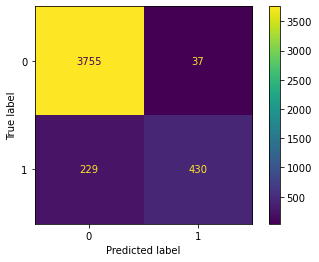

In [82]:
### Evaluate model on validation data
y_pred= model.predict(X_val)
print("Accuracy = " , metrics.accuracy_score(y_val, y_pred))
cm= confusion_matrix(y_val, y_pred)
print(cm)
ConfusionMatrixDisplay(cm, model.classes_).plot()
print(metrics.classification_report(y_val, y_pred, target_names=['nonmatch', 'match']))

from sklearn.metrics import roc_auc_score
# Calculate the ROC score
roc_score = roc_auc_score(y_val, y_pred)

# Print the ROC score
print("ROC Score: {:.4f}".format(roc_score))

Accuracy =  0.7717206132879046
[[446   0]
 [134   7]]
              precision    recall  f1-score   support

    nonmatch       0.77      1.00      0.87       446
       match       1.00      0.05      0.09       141

    accuracy                           0.77       587
   macro avg       0.88      0.52      0.48       587
weighted avg       0.82      0.77      0.68       587

ROC Score: 0.5248


C:\Users\pc\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass display_labels=[0 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


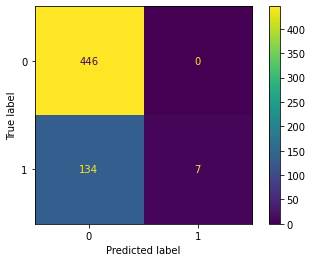

In [83]:
### Evaluate model on test data
y_pred= model.predict(X_test)
print("Accuracy = " , metrics.accuracy_score(y_test, y_pred))
cm= confusion_matrix(y_test, y_pred)
print(cm)
ConfusionMatrixDisplay(cm, model.classes_).plot()
print(metrics.classification_report(y_test, y_pred, target_names=['nonmatch', 'match']))

from sklearn.metrics import roc_auc_score
# Calculate the ROC score
roc_score = roc_auc_score(y_test, y_pred)

# Print the ROC score
print("ROC Score: {:.4f}".format(roc_score))

Accuracy =  0.7892376681614349
[[350   0]
 [ 94   2]]
              precision    recall  f1-score   support

    nonmatch       0.79      1.00      0.88       350
       match       1.00      0.02      0.04        96

    accuracy                           0.79       446
   macro avg       0.89      0.51      0.46       446
weighted avg       0.83      0.79      0.70       446

ROC Score: 0.5104


C:\Users\pc\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass display_labels=[0 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


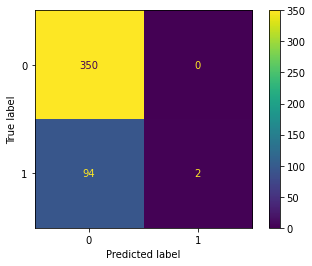

In [84]:
### Evaluate model on gold standard data
y_gs_pred= model.predict(X_gs)
print("Accuracy = " , metrics.accuracy_score(y_gs, y_gs_pred))
cm= confusion_matrix(y_gs, y_gs_pred)
print(cm)
ConfusionMatrixDisplay(cm, model.classes_).plot()
print(metrics.classification_report(y_gs, y_gs_pred, target_names=['nonmatch', 'match']))

from sklearn.metrics import roc_auc_score
# Calculate the ROC score
roc_score = roc_auc_score(y_gs, y_gs_pred)

# Print the ROC score
print("ROC Score: {:.4f}".format(roc_score))

### Hyperparameter Tuning for Random Forest using Randomised Search

###  Implementing Random Search Using Scikit-Learn
##### Defining the Hyperparameter Space

In [85]:
###  Implementing Random Search Using Scikit-Learn
##### Defining the Hyperparameter Space
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV
import numpy as np
rs_space={'max_depth':list(np.arange(1, 100, step=10)) + [None],
              'n_estimators':np.arange(10, 500, step=50),
              'max_features':randint(1,7),
              'criterion':['gini','entropy'],
              'min_samples_leaf':randint(1,4),
              'min_samples_split':np.arange(2, 10, step=2)
         }

rf = RandomForestClassifier()
rf_random = RandomizedSearchCV(rf, rs_space, n_iter=100, scoring='accuracy', n_jobs=-1, cv=3)
model_random = rf_random.fit(X_train,y_train)


print('Best grid search hyperparameters are: '+str(model_random.best_params_))
print('Best grid search score is: '+str(model_random.best_score_))

Best grid search hyperparameters are: {'criterion': 'entropy', 'max_depth': None, 'max_features': 1, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 260}
Best grid search score is: 0.9368198015987672


### Evaluate model on validation data

Accuracy =  0.9418108290271849
[[3762   30]
 [ 229  430]]


C:\Users\pc\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass display_labels=[0 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


              precision    recall  f1-score   support

    nonmatch       0.94      0.99      0.97      3792
       match       0.93      0.65      0.77       659

    accuracy                           0.94      4451
   macro avg       0.94      0.82      0.87      4451
weighted avg       0.94      0.94      0.94      4451

ROC Score: 0.8223


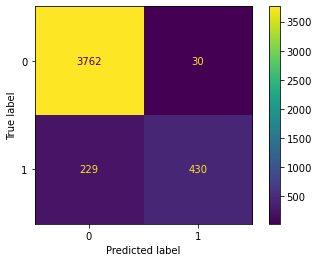

In [87]:
### Evaluate model on validation data
y_pred= model_random.predict(X_val)
print("Accuracy = " , metrics.accuracy_score(y_val, y_pred))
cm= confusion_matrix(y_val, y_pred)
print(cm)
ConfusionMatrixDisplay(cm, model.classes_).plot()
print(metrics.classification_report(y_val, y_pred, target_names=['nonmatch', 'match']))

from sklearn.metrics import roc_auc_score
# Calculate the ROC score
roc_score = roc_auc_score(y_val, y_pred)

# Print the ROC score
print("ROC Score: {:.4f}".format(roc_score))

### Evaluate model using test set

Accuracy =  0.7768313458262351
[[444   2]
 [129  12]]


C:\Users\pc\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass display_labels=[0 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


              precision    recall  f1-score   support

    nonmatch       0.77      1.00      0.87       446
       match       0.86      0.09      0.15       141

    accuracy                           0.78       587
   macro avg       0.82      0.54      0.51       587
weighted avg       0.79      0.78      0.70       587

ROC Score: 0.5403


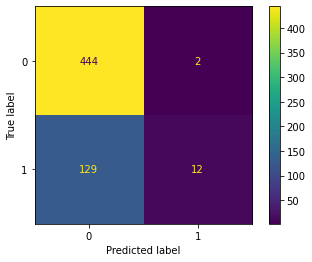

In [88]:
### Evaluate model on test data
y_pred= model_random.predict(X_test)
print("Accuracy = " , metrics.accuracy_score(y_test, y_pred))
cm= confusion_matrix(y_test, y_pred)
print(cm)
ConfusionMatrixDisplay(cm, model.classes_).plot()
print(metrics.classification_report(y_test, y_pred, target_names=['nonmatch', 'match']))

from sklearn.metrics import roc_auc_score
# Calculate the ROC score
roc_score = roc_auc_score(y_test, y_pred)

# Print the ROC score
print("ROC Score: {:.4f}".format(roc_score))

### Evaluate the model using gold standard data

Accuracy =  0.7937219730941704
[[349   1]
 [ 91   5]]
              precision    recall  f1-score   support

    nonmatch       0.79      1.00      0.88       350
       match       0.83      0.05      0.10        96

    accuracy                           0.79       446
   macro avg       0.81      0.52      0.49       446
weighted avg       0.80      0.79      0.71       446

ROC Score: 0.5246


C:\Users\pc\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass display_labels=[0 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


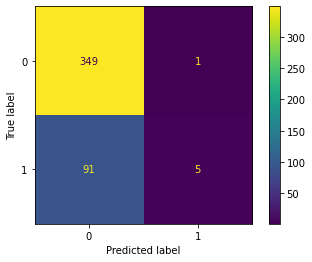

In [89]:
### Evaluate model on gold standard data
y_gs_pred= model_random.predict(X_gs)
print("Accuracy = " , metrics.accuracy_score(y_gs, y_gs_pred))
cm= confusion_matrix(y_gs, y_gs_pred)
print(cm)
ConfusionMatrixDisplay(cm, model.classes_).plot()
print(metrics.classification_report(y_gs, y_gs_pred, target_names=['nonmatch', 'match']))

from sklearn.metrics import roc_auc_score
# Calculate the ROC score
roc_score = roc_auc_score(y_gs, y_gs_pred)

# Print the ROC score
print("ROC Score: {:.4f}".format(roc_score))

# Experiment Three
#### WORKING WITH COLUMNS WITH LESS THAN 40,000 MISSING VALUES ,THEN REPLACING THE NULL VALUES WITH BLANKS

In [90]:
data2a = data.drop(['specTableContent_left' , 'specTableContent_right' , 'keyValuePairs_left' , 'keyValuePairs_right' , 'price_left' , 'price_right'] , axis=1)
data2a = data2a.fillna('')
test_set2a= test_set.drop(['specTableContent_left' , 'specTableContent_right' , 'keyValuePairs_left' , 'keyValuePairs_right' , 'price_left' , 'price_right'] , axis=1)
data_gs2a= data_gs.drop(['specTableContent_left' , 'specTableContent_right' , 'keyValuePairs_left' , 'keyValuePairs_right' , 'price_left' , 'price_right'] , axis=1)

In [92]:
data2a=data2a.dropna()
test_set2a= test_set2a.dropna()
data_gs2a =data_gs2a.dropna()

print('data2a.shape',data2a.shape)
print('test_set2a.shape',test_set2a.shape)
print('data_gs2a.shape' , data_gs2a.shape)


data2a.shape (68461, 14)
test_set2a.shape (587, 14)
data_gs2a.shape (446, 14)


## Merging of culumns

In [93]:
data2a['product_feature'] = str(data2a['id_left']) + " " + data2a['title_left'] +" " + data2a['description_left'] + " " + data2a['brand_left'] + " " + data2a['category_left'] + " " + str(data2a['cluster_id_left']) + " " + str(data2a['id_right']) + " " + data2a['title_right'] + " " + data2a['description_right'] + " " + data2a['brand_right'] + " " + data2a['category_right'] +" " + str(data2a['cluster_id_right']) + " " + str(data2a['pair_id'])
data2a.drop(data2a.columns.difference(['product_feature','label']), 1, inplace=True)

test_set2a['product_feature'] = str(test_set2a['id_left']) + " " + test_set2a['title_left'] +" " + test_set2a['description_left'] + " " + test_set2a['brand_left'] + " " + test_set2a['category_left'] + " " + str(test_set2a['cluster_id_left']) + " " + str(test_set2a['id_right']) + " " + test_set2a['title_right'] + " " + test_set2a['description_right'] + " " + test_set2a['brand_right'] + " " + test_set2a['category_right'] +" " + str(test_set2a['cluster_id_right']) + " " + str(test_set2a['pair_id'])
test_set2a.drop(test_set2a.columns.difference(['product_feature','label']), 1, inplace=True)

data_gs2a['product_feature'] = str(data_gs2a['id_left']) + " " + data_gs2a['title_left'] +" " + data_gs2a['description_left'] + " " + data_gs2a['brand_left'] + " " + data_gs2a['category_left'] + " " + str(data_gs2a['cluster_id_left']) + " " + str(data_gs2a['id_right']) + " " + data_gs2a['title_right'] + " " + data_gs2a['description_right'] + " " + data_gs2a['brand_right'] + " " + data_gs2a['category_right'] +" " + str(data_gs2a['cluster_id_right']) + " " + str(data_gs2a['pair_id'])
data_gs2a.drop(data_gs2a.columns.difference(['product_feature','label']), 1, inplace=True)


C:\Users\pc\AppData\Local\Temp/ipykernel_4272/2655543665.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  data2a.drop(data2a.columns.difference(['product_feature','label']), 1, inplace=True)
C:\Users\pc\AppData\Local\Temp/ipykernel_4272/2655543665.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  test_set2a.drop(test_set2a.columns.difference(['product_feature','label']), 1, inplace=True)
C:\Users\pc\AppData\Local\Temp/ipykernel_4272/2655543665.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  data_gs2a.drop(data_gs2a.columns.difference(['product_feature','label']), 1, inplace=True)


### Shape of data after column merge

In [94]:
print('data2a.shape',data2a.shape)
print('test_set2a.shape',test_set2a.shape)
print('data_gs2a.shape' , data_gs2a.shape)

data2a.shape (68461, 2)
test_set2a.shape (587, 2)
data_gs2a.shape (446, 2)


#### Apply the function remove_punctuation to columns

In [95]:
data2a['product_feature'] = data2a['product_feature'].apply(lambda x:remove_punctuation(x))
test_set2a['product_feature'] = test_set2a['product_feature'].apply(lambda x:remove_punctuation(x))
data_gs2a['product_feature'] = data_gs2a['product_feature'].apply(lambda x:remove_punctuation(x))


#### Create tfidf instance

In [96]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(tokenizer=tokenize , 
                             stop_words=english_stopwords,
                            ngram_range=(1,1) ,max_df=0.5 , max_features=1000
                            )

#### Passing in the text into vectorizer

In [97]:
vectorizer.fit(data2a.product_feature)

C:\Users\pc\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:489: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"
C:\Users\pc\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'s", 'abov', 'ani', 'becaus', 'befor', 'could', 'doe', 'dure', 'might', 'must', "n't", 'need', 'onc', 'onli', 'ourselv', 'sha', 'themselv', 'veri', 'whi', 'wo', 'would', 'yourselv'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


TfidfVectorizer(max_df=0.5, max_features=1000,
                stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours',
                            'ourselves', 'you', "you're", "you've", "you'll",
                            "you'd", 'your', 'yours', 'yourself', 'yourselves',
                            'he', 'him', 'his', 'himself', 'she', "she's",
                            'her', 'hers', 'herself', 'it', "it's", 'its',
                            'itself', ...],
                tokenizer=<function tokenize at 0x00000271809C6D30>)

#### Transform training , test and gold standard datasets

In [98]:
inputs = pd.DataFrame(vectorizer.transform(data2a["product_feature"]).toarray(), columns=vectorizer.vocabulary_)
test_inputs = pd.DataFrame(vectorizer.transform(test_set2a.product_feature).toarray(), columns=vectorizer.vocabulary_)
gs_inputs = pd.DataFrame(vectorizer.transform(data_gs2a.product_feature).toarray(), columns=vectorizer.vocabulary_)


print('inputs.shape:' , inputs.shape)
print('test_inputs.shape' , test_inputs.shape)
print('gs_inputs.shape' , gs_inputs.shape)


inputs.shape: (68461, 1000)
test_inputs.shape (587, 1000)
gs_inputs.shape (446, 1000)


#### Split the Training data into train and validation 

In [99]:
X_train , X_val , y_train , y_val = train_test_split(inputs , data2a.label , test_size= 0.3 , random_state=42)

X_test=test_inputs 
y_test = test_set2a.label

X_gs =gs_inputs
y_gs= data_gs2a.label


#### Initial Accuracy Test for Potential Models using K fold Evaluation

In [100]:
seed = 42
models = []
models.append(('LR', LogisticRegression(solver='sag')))
models.append(('RF', RandomForestClassifier()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
#models.append(('NB', GaussianNB()))


#Evaluate each model
results = []
names = []
scoring = 'accuracy'

for name, model in models:
    kfold = model_selection.KFold(n_splits = 10, random_state = seed , shuffle=True)
    cv_results = model_selection.cross_val_score(model,X_train , y_train.ravel(), cv=kfold, scoring=scoring)
    model.fit(X_train, y_train)
    Y_pred = model.predict(X_val)
    
    results.append(cv_results)
    names.append(name)
    print('Model Name: ' , name)
    print('Cross value mean: ' , cv_results.mean())
    print('Cross value Standard Deviation: ', cv_results.std())
    print('\nClassification Report')
    print(classification_report(y_val, Y_pred))
    print('=================================================================\n')
    
    


Model Name:  LR
Cross value mean:  0.8646757914557506
Cross value Standard Deviation:  0.005731304291378829

Classification Report
              precision    recall  f1-score   support

           0       0.86      1.00      0.92     17568
           1       0.77      0.06      0.11      2971

    accuracy                           0.86     20539
   macro avg       0.81      0.53      0.52     20539
weighted avg       0.85      0.86      0.81     20539


Model Name:  RF
Cross value mean:  0.8972705918167388
Cross value Standard Deviation:  0.004740596702799753

Classification Report
              precision    recall  f1-score   support

           0       0.91      0.98      0.94     17568
           1       0.76      0.43      0.55      2971

    accuracy                           0.90     20539
   macro avg       0.83      0.70      0.74     20539
weighted avg       0.89      0.90      0.88     20539


Model Name:  KNN
Cross value mean:  0.8653852202380559
Cross value Standard Deviat

KeyboardInterrupt: 

### Fit the Random Forest Model

In [101]:
model = RandomForestClassifier(random_state=42)
model.fit(X_train , y_train )

RandomForestClassifier(random_state=42)

### Evaluate model using validation set

Accuracy =  0.8976094259701056
[[17170   398]
 [ 1705  1266]]


C:\Users\pc\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass display_labels=[0 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


              precision    recall  f1-score   support

    nonmatch       0.91      0.98      0.94     17568
       match       0.76      0.43      0.55      2971

    accuracy                           0.90     20539
   macro avg       0.84      0.70      0.74     20539
weighted avg       0.89      0.90      0.89     20539

ROC Score: 0.7017


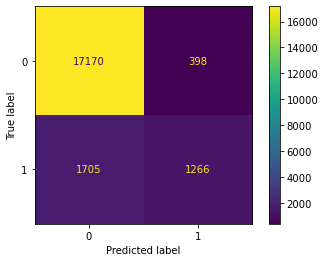

In [102]:
### Evaluate model on validation data
y_pred= model.predict(X_val)
print("Accuracy = " , metrics.accuracy_score(y_val, y_pred))
cm= confusion_matrix(y_val, y_pred)
print(cm)
ConfusionMatrixDisplay(cm, model.classes_).plot()
print(metrics.classification_report(y_val, y_pred, target_names=['nonmatch', 'match']))

from sklearn.metrics import roc_auc_score
# Calculate the ROC score
roc_score = roc_auc_score(y_val, y_pred)

# Print the ROC score
print("ROC Score: {:.4f}".format(roc_score))

### Evaluate model on test data

Accuracy =  0.7649063032367973
[[445   1]
 [137   4]]
              precision    recall  f1-score   support

    nonmatch       0.76      1.00      0.87       446
       match       0.80      0.03      0.05       141

    accuracy                           0.76       587
   macro avg       0.78      0.51      0.46       587
weighted avg       0.77      0.76      0.67       587

ROC Score: 0.5131


C:\Users\pc\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass display_labels=[0 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


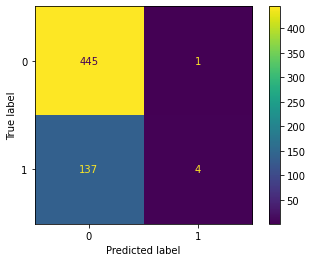

In [103]:
### Evaluate model on test data
y_pred= model.predict(X_test)
print("Accuracy = " , metrics.accuracy_score(y_test, y_pred))
cm= confusion_matrix(y_test, y_pred)
print(cm)
ConfusionMatrixDisplay(cm, model.classes_).plot()
print(metrics.classification_report(y_test, y_pred, target_names=['nonmatch', 'match']))

from sklearn.metrics import roc_auc_score
# Calculate the ROC score
roc_score = roc_auc_score(y_test, y_pred)

# Print the ROC score
print("ROC Score: {:.4f}".format(roc_score))


### Evaluate model on gold standard data

Accuracy =  0.7892376681614349
[[347   3]
 [ 91   5]]
              precision    recall  f1-score   support

    nonmatch       0.79      0.99      0.88       350
       match       0.62      0.05      0.10        96

    accuracy                           0.79       446
   macro avg       0.71      0.52      0.49       446
weighted avg       0.76      0.79      0.71       446

ROC Score: 0.5218


C:\Users\pc\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass display_labels=[0 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


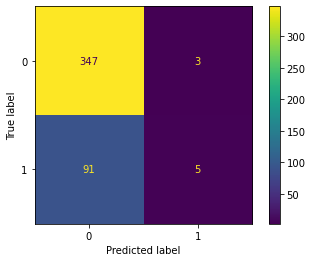

In [104]:
### Evaluate model on gold standard data
y_gs_pred= model.predict(X_gs)
print("Accuracy = " , metrics.accuracy_score(y_gs, y_gs_pred))
cm= confusion_matrix(y_gs, y_gs_pred)
print(cm)
ConfusionMatrixDisplay(cm, model.classes_).plot()
print(metrics.classification_report(y_gs, y_gs_pred, target_names=['nonmatch', 'match']))

from sklearn.metrics import roc_auc_score
# Calculate the ROC score
roc_score = roc_auc_score(y_gs, y_gs_pred)

# Print the ROC score
print("ROC Score: {:.4f}".format(roc_score))

## EXPERIMENT FOUR

## Working with COLUMNS WITH less than 20,000 missing values and brand

#### Recall the (train & validation) data above

In [ ]:
print("Are there any null values?")
print(data.isnull().values.any() , "\n")
#Find out how many - This gives you the breakdown per column
print('How many null values are in each column?'),
print(data.isnull().sum(), "\n")
#Get total overall null values
print('How many null values are in the data in total?')
print(data.isnull().sum().sum())

- The columns that satisfy our condition of using columns with less than 20,000 null values are:
- id_left , title_left , description_left , category_left, , cluster_id_left , id_right , title_right, description_right, category_right , and cluster_id_right. I will also exclude pair_id because it is a combination of id_left and id_right.
- this means that I will be using the ten features listed above.


### Drop the excluded columns , null values and merge the remaining features into one column

In [143]:
# Drop excluded columns
data3 = data.drop(['specTableContent_left' , 'specTableContent_right' , 'keyValuePairs_left' , 'keyValuePairs_right' , 'price_left' , 'price_right','description_left' , 'description_right', 'pair_id'] , axis=1)
test_set3= test_set.drop(['specTableContent_left' , 'specTableContent_right' , 'keyValuePairs_left' , 'keyValuePairs_right' , 'price_left' , 'price_right','description_left' , 'description_right', 'pair_id'] , axis=1)
data_gs3= data_gs.drop(['specTableContent_left' , 'specTableContent_right' , 'keyValuePairs_left' , 'keyValuePairs_right' , 'price_left' , 'price_right','description_left' , 'description_right', 'pair_id'] , axis=1)

# Drop null values
data3=data3.dropna()
test_set3= test_set3.dropna()
data_gs3 =data_gs3.dropna()


data3['product_feature'] = str(data3['id_left']) + " " + data3['title_left'] + "" +data3['brand_left'] + " " + data3['category_left'] + " " + str(data3['cluster_id_left']) + " " + str(data3['id_right']) + " " + data3['title_right'] +  data3['brand_right'] + " " + data3['category_right'] +" " + str(data3['cluster_id_right'])
data3.drop(data3.columns.difference(['product_feature','label']), 1, inplace=True)

test_set3['product_feature'] = str(test_set3['id_left']) + " " + test_set3['title_left'] + "" + str(test_set3['brand_left']) + " " + test_set3['category_left'] + " " + str(test_set3['cluster_id_left']) + " " + str(test_set3['id_right']) + " " + test_set3['title_right'] +  test_set3['brand_right'] + " " + test_set3['category_right'] +" " + str(test_set3['cluster_id_right'])
test_set3.drop(test_set3.columns.difference(['product_feature','label']), 1, inplace=True)

data_gs3['product_feature'] = str(data_gs3['id_left']) + " " + data_gs3['title_left'] + "" + str(data_gs3['brand_left']) + " " + data_gs3['category_left'] + " " + str(data_gs3['cluster_id_left']) + " " + str(data_gs3['id_right']) + " " + data_gs3['title_right'] +  data_gs3['brand_right'] + " " + data_gs3['category_right'] +" " + str(data_gs3['cluster_id_right'])
data_gs3.drop(data_gs3.columns.difference(['product_feature','label']), 1, inplace=True)


C:\Users\pc\AppData\Local\Temp/ipykernel_4272/4237739595.py:13: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  data3.drop(data3.columns.difference(['product_feature','label']), 1, inplace=True)
C:\Users\pc\AppData\Local\Temp/ipykernel_4272/4237739595.py:16: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  test_set3.drop(test_set3.columns.difference(['product_feature','label']), 1, inplace=True)
C:\Users\pc\AppData\Local\Temp/ipykernel_4272/4237739595.py:19: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  data_gs3.drop(data_gs3.columns.difference(['product_feature','label']), 1, inplace=True)


In [144]:
data3.shape

(21559, 2)

## Remove punctuations from features

In [145]:
data3['product_feature'] = data3['product_feature'].apply(lambda x:remove_punctuation(x))
test_set3['product_feature'] = test_set3['product_feature'].apply(lambda x:remove_punctuation(x))
data_gs3['product_feature'] = data_gs3['product_feature'].apply(lambda x:remove_punctuation(x))

#### Passing in the text into vectorizer

In [146]:
inputs= vectorizer.transform(data3.product_feature)
print('inputs shape:' ,inputs.shape)

test_inputs= vectorizer.transform(test_set3.product_feature)
print('test_inputs shape:',test_inputs.shape)

gs_inputs= vectorizer.transform(data_gs3.product_feature)
print('gs_inputs shape:',gs_inputs.shape)

inputs shape: (21559, 1000)
test_inputs shape: (666, 1000)
gs_inputs shape: (501, 1000)


### Splitting data into train and validation , test and gold standard into features and labels

In [147]:
X_train , X_val , y_train , y_val = train_test_split(inputs , data3.label , test_size= 0.3 , random_state=42)

X_test=test_inputs 
y_test = test_set3.label

X_gs =gs_inputs
y_gs= data_gs3.label

#### Initial Accuracy Test for Potential Models using K fold Evaluation

In [110]:
seed = 42
models = []
models.append(('LR', LogisticRegression()))
models.append(('RF', RandomForestClassifier()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
#models.append(('NB', GaussianNB()))


#Evaluate each model
results = []
names = []
scoring = 'accuracy'

for name, model in models:
    kfold = model_selection.KFold(n_splits = 10, random_state = seed , shuffle=True)
    cv_results = model_selection.cross_val_score(model,X_train , y_train.ravel(), cv=kfold, scoring=scoring)
    model.fit(X_train, y_train)
    Y_pred = model.predict(X_val)
    
    results.append(cv_results)
    names.append(name)
    print('Model Name: ' , name)
    print('Cross value mean: ' , cv_results.mean())
    print('Cross value Standard Deviation: ', cv_results.std())
    print('\nClassification Report')
    print(classification_report(y_val, Y_pred))
    print('=================================================================\n')
    
    


C:\Users\pc\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\pc\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Model Name:  LR
Cross value mean:  0.8619708679490387
Cross value Standard Deviation:  0.0077199287705521456

Classification Report
              precision    recall  f1-score   support

           0       0.86      1.00      0.93      5482
           1       0.87      0.12      0.22       986

    accuracy                           0.86      6468
   macro avg       0.86      0.56      0.57      6468
weighted avg       0.86      0.86      0.82      6468


Model Name:  RF
Cross value mean:  0.905307580565174
Cross value Standard Deviation:  0.006512609945920104

Classification Report
              precision    recall  f1-score   support

           0       0.93      0.97      0.95      5482
           1       0.80      0.56      0.66       986

    accuracy                           0.91      6468
   macro avg       0.86      0.77      0.80      6468
weighted avg       0.91      0.91      0.91      6468


Model Name:  KNN
Cross value mean:  0.9006030044896185
Cross value Standard Deviat

the model is not better than the first model

### Fit the Random Forest Model

In [148]:
### Fit the Random Forest Model

model = RandomForestClassifier(random_state=42)
model.fit(X_train , y_train )

RandomForestClassifier(random_state=42)

### Evaluate model on validation data

Accuracy =  0.909400123685838
[[5333  149]
 [ 437  549]]


C:\Users\pc\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass display_labels=[0 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


              precision    recall  f1-score   support

    nonmatch       0.92      0.97      0.95      5482
       match       0.79      0.56      0.65       986

    accuracy                           0.91      6468
   macro avg       0.86      0.76      0.80      6468
weighted avg       0.90      0.91      0.90      6468

ROC Score: 0.7648


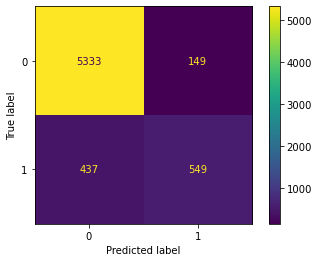

In [149]:
### Evaluate model on validation data
y_pred= model.predict(X_val)
print("Accuracy = " , metrics.accuracy_score(y_val, y_pred))
cm= confusion_matrix(y_val, y_pred)
print(cm)
ConfusionMatrixDisplay(cm, model.classes_).plot()
print(metrics.classification_report(y_val, y_pred, target_names=['nonmatch', 'match']))

from sklearn.metrics import roc_auc_score
# Calculate the ROC score
roc_score = roc_auc_score(y_val, y_pred)

# Print the ROC score
print("ROC Score: {:.4f}".format(roc_score))


## Evaluate model on test data

Accuracy =  0.7222222222222222
[[471   6]
 [179  10]]
              precision    recall  f1-score   support

    nonmatch       0.72      0.99      0.84       477
       match       0.62      0.05      0.10       189

    accuracy                           0.72       666
   macro avg       0.67      0.52      0.47       666
weighted avg       0.70      0.72      0.63       666

ROC Score: 0.5202


C:\Users\pc\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass display_labels=[0 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


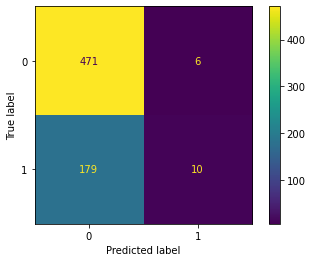

In [150]:
## Evaluate model on test data
y_pred= model.predict(X_test)
print("Accuracy = " , metrics.accuracy_score(y_test, y_pred))
cm= confusion_matrix(y_test, y_pred)
print(cm)
ConfusionMatrixDisplay(cm, model.classes_).plot()
print(metrics.classification_report(y_test, y_pred, target_names=['nonmatch', 'match']))

from sklearn.metrics import roc_auc_score
# Calculate the ROC score
roc_score = roc_auc_score(y_test, y_pred)

# Print the ROC score
print("ROC Score: {:.4f}".format(roc_score))

### Evaluate model on gold standard data

Accuracy =  0.6626746506986028
[[290  89]
 [ 80  42]]
              precision    recall  f1-score   support

    nonmatch       0.78      0.77      0.77       379
       match       0.32      0.34      0.33       122

    accuracy                           0.66       501
   macro avg       0.55      0.55      0.55       501
weighted avg       0.67      0.66      0.67       501

ROC Score: 0.5547


C:\Users\pc\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass display_labels=[0 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


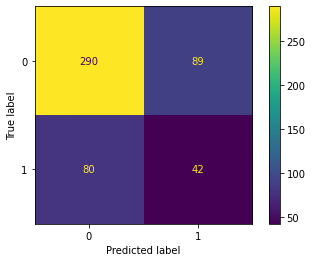

In [152]:
### Evaluate model on gold standard data
y_gs_pred= model.predict(X_gs)
print("Accuracy = " , metrics.accuracy_score(y_gs, y_gs_pred))
cm= confusion_matrix(y_gs, y_gs_pred)
print(cm)
ConfusionMatrixDisplay(cm, model.classes_).plot()
print(metrics.classification_report(y_gs, y_gs_pred, target_names=['nonmatch', 'match']))

from sklearn.metrics import roc_auc_score
# Calculate the ROC score
roc_score = roc_auc_score(y_gs, y_gs_pred)

# Print the ROC score
print("ROC Score: {:.4f}".format(roc_score))

## EXPERIMENT FIVE

### USING BASIC COLUMNS : id, title and brand only

In [116]:
data4 = data.copy(deep=True) 
data4.drop(data4.columns.difference(['id_left','title_left', 'brand_left', 'id_right' , 'title_right', 'brand_right','label']), 1, inplace=True)

test_set4= test_set.copy(deep=True) 
test_set4.drop(test_set4.columns.difference(['id_left','title_left', 'brand_left', 'id_right' , 'title_right','brand_right','label']), 1, inplace=True)

data_gs4= data_gs.copy(deep=True) 
data_gs4.drop(data_gs4.columns.difference(['id_left','title_left', 'brand_left', 'id_right' , 'title_right','brand_right','label']), 1, inplace=True)


# Drop null values
data4=data4.dropna()
test_set4= test_set4.dropna()
data_gs4 =data_gs4.dropna()

C:\Users\pc\AppData\Local\Temp/ipykernel_4272/2410474713.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  data4.drop(data4.columns.difference(['id_left','title_left', 'brand_left', 'id_right' , 'title_right', 'brand_right','label']), 1, inplace=True)
C:\Users\pc\AppData\Local\Temp/ipykernel_4272/2410474713.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  test_set4.drop(test_set4.columns.difference(['id_left','title_left', 'brand_left', 'id_right' , 'title_right','brand_right','label']), 1, inplace=True)
C:\Users\pc\AppData\Local\Temp/ipykernel_4272/2410474713.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  data_gs4.drop(data_gs4.columns.difference(['id_left','title_left', 'brand_left', 'id_right' , 'title_right','brand_

### Merging the features into one column and removing punctuations from the column

In [117]:
data4['product_feature']=  str(data4['id_left']) + " " + data4['title_left'] +" " + data4['brand_left'] + str(data4['id_right']) + " " + data4['title_right'] +" " + data4['brand_right']
data4.drop(data4.columns.difference(['product_feature','label']), 1, inplace=True)

test_set4['product_feature']=  str(test_set4['id_left']) + " " + test_set4['title_left'] +" " + test_set4['brand_left'] + str(test_set4['id_right']) + " " + test_set4['title_right'] +" " + test_set4['brand_right']
test_set4.drop(test_set4.columns.difference(['product_feature','label']), 1, inplace=True)

data_gs4['product_feature']=  str(data_gs4['id_left']) + " " + data_gs4['title_left'] +" " + data_gs4['brand_left'] + str(data_gs4['id_right']) + " " + data_gs4['title_right'] +" " + data_gs4['brand_right']
data_gs4.drop(data_gs4.columns.difference(['product_feature','label']), 1, inplace=True)

#REmove punctuations
data4['product_feature'] = data4['product_feature'].apply(lambda x:remove_punctuation(x))
test_set4['product_feature'] = test_set4['product_feature'].apply(lambda x:remove_punctuation(x))
data_gs4['product_feature'] = data_gs4['product_feature'].apply(lambda x:remove_punctuation(x))

C:\Users\pc\AppData\Local\Temp/ipykernel_4272/3440122692.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  data4.drop(data4.columns.difference(['product_feature','label']), 1, inplace=True)
C:\Users\pc\AppData\Local\Temp/ipykernel_4272/3440122692.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  test_set4.drop(test_set4.columns.difference(['product_feature','label']), 1, inplace=True)
C:\Users\pc\AppData\Local\Temp/ipykernel_4272/3440122692.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  data_gs4.drop(data_gs4.columns.difference(['product_feature','label']), 1, inplace=True)


In [ ]:
data_gs4.head()

### Passing in the text into vectorizer

In [119]:
inputs= vectorizer.transform(data4.product_feature)
print('inputs shape:' ,inputs.shape)

test_inputs= vectorizer.transform(test_set4.product_feature)
print('test_inputs shape:',test_inputs.shape)

gs_inputs= vectorizer.transform(data_gs4.product_feature)
print('gs_inputs shape:',gs_inputs.shape)

inputs shape: (21559, 1000)
test_inputs shape: (666, 1000)
gs_inputs shape: (501, 1000)


#### Split the Training data into train and validation 

In [120]:
X_train , X_val , y_train , y_val = train_test_split(inputs , data4.label , test_size= 0.3 , random_state=42)

X_test=test_inputs 
y_test = test_set4.label

X_gs =gs_inputs
y_gs= data_gs4.label

#### Initial Accuracy Test for Potential Models using K fold Evaluation

In [121]:
seed = 42
models = []
models.append(('LR', LogisticRegression()))
models.append(('RF', RandomForestClassifier()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
#models.append(('NB', GaussianNB()))


#Evaluate each model
results = []
names = []
scoring = 'accuracy'

for name, model in models:
    kfold = model_selection.KFold(n_splits = 10, random_state = seed , shuffle=True)
    cv_results = model_selection.cross_val_score(model,X_train , y_train.ravel(), cv=kfold, scoring=scoring)
    model.fit(X_train, y_train)
    Y_pred = model.predict(X_val)
    
    results.append(cv_results)
    names.append(name)
    print('Model Name: ' , name)
    print('Cross value mean: ' , cv_results.mean())
    print('Cross value Standard Deviation: ', cv_results.std())
    print('\nClassification Report')
    print(classification_report(y_val, Y_pred))
    print('=================================================================\n')
    
    


Model Name:  LR
Cross value mean:  0.8617720607919811
Cross value Standard Deviation:  0.007777691935759594

Classification Report
              precision    recall  f1-score   support

           0       0.86      1.00      0.93      5482
           1       0.84      0.13      0.22       986

    accuracy                           0.86      6468
   macro avg       0.85      0.56      0.57      6468
weighted avg       0.86      0.86      0.82      6468


Model Name:  RF
Cross value mean:  0.9100122005275193
Cross value Standard Deviation:  0.0062906284313187285

Classification Report
              precision    recall  f1-score   support

           0       0.93      0.98      0.95      5482
           1       0.81      0.56      0.66       986

    accuracy                           0.91      6468
   macro avg       0.87      0.77      0.81      6468
weighted avg       0.91      0.91      0.91      6468


Model Name:  KNN
Cross value mean:  0.8967596627739084
Cross value Standard Devia

### Fit the Random Forest Model

In [122]:
model = RandomForestClassifier(random_state=42)
model.fit(X_train , y_train )

RandomForestClassifier(random_state=42)

### Evaluate model using validation set



Accuracy =  0.9129560915275201
[[5352  130]
 [ 433  553]]
              precision    recall  f1-score   support

    nonmatch       0.93      0.98      0.95      5482
       match       0.81      0.56      0.66       986

    accuracy                           0.91      6468
   macro avg       0.87      0.77      0.81      6468
weighted avg       0.91      0.91      0.91      6468

ROC Score: 0.7686


C:\Users\pc\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass display_labels=[0 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


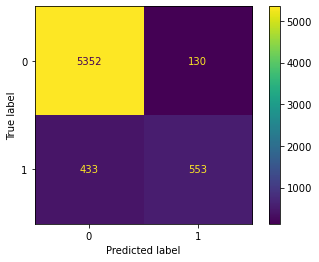

In [124]:
### Evaluate model on validation data
y_pred= model.predict(X_val)
print("Accuracy = " , metrics.accuracy_score(y_val, y_pred))
cm= confusion_matrix(y_val, y_pred)
print(cm)
ConfusionMatrixDisplay(cm, model.classes_).plot()
print(metrics.classification_report(y_val, y_pred, target_names=['nonmatch', 'match']))

from sklearn.metrics import roc_auc_score
# Calculate the ROC score
roc_score = roc_auc_score(y_val, y_pred)

# Print the ROC score
print("ROC Score: {:.4f}".format(roc_score))


### Evaluate model on test data

Accuracy =  0.6546546546546547
[[347 130]
 [100  89]]
              precision    recall  f1-score   support

    nonmatch       0.78      0.73      0.75       477
       match       0.41      0.47      0.44       189

    accuracy                           0.65       666
   macro avg       0.59      0.60      0.59       666
weighted avg       0.67      0.65      0.66       666

ROC Score: 0.5992


C:\Users\pc\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass display_labels=[0 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


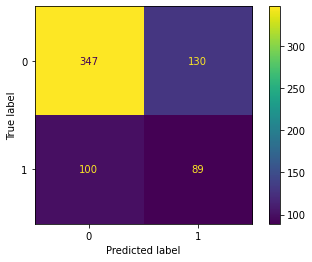

In [125]:
### Evaluate model on test data
y_pred= model.predict(X_test)
print("Accuracy = " , metrics.accuracy_score(y_test, y_pred))
cm= confusion_matrix(y_test, y_pred)
print(cm)
ConfusionMatrixDisplay(cm, model.classes_).plot()
print(metrics.classification_report(y_test, y_pred, target_names=['nonmatch', 'match']))

from sklearn.metrics import roc_auc_score
# Calculate the ROC score
roc_score = roc_auc_score(y_test, y_pred)

# Print the ROC score
print("ROC Score: {:.4f}".format(roc_score))


### Evaluate model on gold standard data

Accuracy =  0.5409181636726547
[[176 203]
 [ 27  95]]
              precision    recall  f1-score   support

    nonmatch       0.87      0.46      0.60       379
       match       0.32      0.78      0.45       122

    accuracy                           0.54       501
   macro avg       0.59      0.62      0.53       501
weighted avg       0.73      0.54      0.57       501

ROC Score: 0.6215


C:\Users\pc\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass display_labels=[0 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


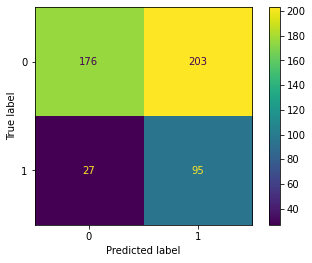

In [126]:

y_gs_pred= model.predict(X_gs)
print("Accuracy = " , metrics.accuracy_score(y_gs, y_gs_pred))
cm= confusion_matrix(y_gs, y_gs_pred)
print(cm)
ConfusionMatrixDisplay(cm, model.classes_).plot()
print(metrics.classification_report(y_gs, y_gs_pred, target_names=['nonmatch', 'match']))

from sklearn.metrics import roc_auc_score
# Calculate the ROC score
roc_score = roc_auc_score(y_gs, y_gs_pred)

# Print the ROC score
print("ROC Score: {:.4f}".format(roc_score))

### Hyperparameter Tuning for Random Forest using Randomised Search
###  Implementing Random Search Using Scikit-Learn
##### Defining the Hyperparameter Space and fitting the model

In [127]:
from scipy.stats import randint
import numpy as np
rs_space={'max_depth':list(np.arange(1, 100, step=10)) + [None],
              'n_estimators':np.arange(10, 500, step=50),
              'max_features':randint(1,7),
              'criterion':['gini','entropy'],
              'min_samples_leaf':randint(1,4),
              'min_samples_split':np.arange(2, 10, step=2)
         }

from sklearn.model_selection import RandomizedSearchCV

rf = RandomForestClassifier()
rf_random = RandomizedSearchCV(rf, rs_space, n_iter=100, scoring='accuracy', n_jobs=-1, cv=3)
model_random = rf_random.fit(X_train,y_train)

print('Best grid search hyperparameters are: '+str(model_random.best_params_))
print('Best grid search score is: '+str(model_random.best_score_))

Best grid search hyperparameters are: {'criterion': 'gini', 'max_depth': None, 'max_features': 4, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 410}
Best grid search score is: 0.9048440161390369


## Fit the model with the best parameters

In [128]:
rf_best = RandomForestClassifier(criterion='gini' ,max_features=1,min_samples_leaf=1,min_samples_split=2,n_estimators=360 )
rf_best.fit(X_train , y_train )

RandomForestClassifier(max_features=1, n_estimators=360)

In [129]:
y_pred= model_random.predict(X_val)

In [130]:
accuracy_score(y_val, y_pred)

0.9115646258503401

In [131]:
from sklearn.metrics import roc_auc_score
# Calculate the ROC score
roc_score = roc_auc_score(y_val, y_pred)

# Print the ROC score
print("ROC Score: {:.4f}".format(roc_score))

ROC Score: 0.7574


### Evaluate model on test data

Accuracy =  0.7282282282282282
[[463  14]
 [167  22]]


C:\Users\pc\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass display_labels=[0 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


              precision    recall  f1-score   support

    nonmatch       0.73      0.97      0.84       477
       match       0.61      0.12      0.20       189

    accuracy                           0.73       666
   macro avg       0.67      0.54      0.52       666
weighted avg       0.70      0.73      0.65       666

ROC Score: 0.5435


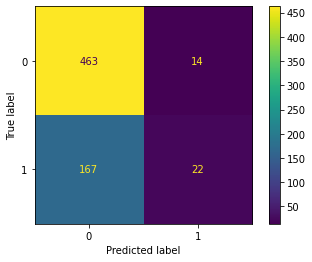

In [132]:
### Evaluate model on test data
y_pred= model_random.predict(X_test)
print("Accuracy = " , metrics.accuracy_score(y_test, y_pred))
cm= confusion_matrix(y_test, y_pred)
print(cm)
ConfusionMatrixDisplay(cm, model.classes_).plot()
print(metrics.classification_report(y_test, y_pred, target_names=['nonmatch', 'match']))

from sklearn.metrics import roc_auc_score
# Calculate the ROC score
roc_score = roc_auc_score(y_test, y_pred)

# Print the ROC score
print("ROC Score: {:.4f}".format(roc_score))

### Evaluate model on gold standard data

Accuracy =  0.780439121756487
[[365  14]
 [ 96  26]]
              precision    recall  f1-score   support

    nonmatch       0.79      0.96      0.87       379
       match       0.65      0.21      0.32       122

    accuracy                           0.78       501
   macro avg       0.72      0.59      0.60       501
weighted avg       0.76      0.78      0.74       501

ROC Score: 0.5881


C:\Users\pc\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass display_labels=[0 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


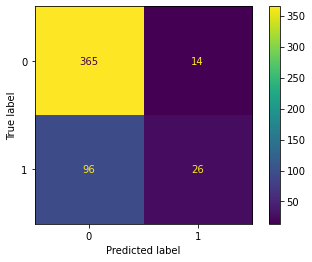

In [133]:
### Evaluate model on gold standard data
y_gs_pred= model_random.predict(X_gs)
print("Accuracy = " , metrics.accuracy_score(y_gs, y_gs_pred))
cm= confusion_matrix(y_gs, y_gs_pred)
print(cm)
ConfusionMatrixDisplay(cm, model.classes_).plot()
print(metrics.classification_report(y_gs, y_gs_pred, target_names=['nonmatch', 'match']))

from sklearn.metrics import roc_auc_score
# Calculate the ROC score
roc_score = roc_auc_score(y_gs, y_gs_pred)

# Print the ROC score
print("ROC Score: {:.4f}".format(roc_score))